<a href="https://colab.research.google.com/github/mkmritunjay/machineLearning/blob/master/Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Credit Risk Analysis

**Goal or objective:**

We will try to predict if a customer is bad when he applies for a loan. It's also called as probability of default (PD).

**Data Preprocessing:**

- Missing value treatment
- outlier treatment
- univariate analysis

###Data Exploratory Analysis:

    - Bivariate Analysis - Numeric(t-test) and Categorical(Chi-square test)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity

###Model Building and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy
###Model Validation
    - OOS validation - p-value and sign testing for the model co-efficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the population




In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

url = 'https://raw.githubusercontent.com/mkmritunjay/machineLearning/master/bankloans.csv'

<Figure size 720x540 with 0 Axes>

In [33]:
bankloan_df = pd.read_csv(url)
bankloan_df.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [34]:
# get the high level overview of columns and their data types
bankloan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [0]:
# separate numerical and categorical variables(no categorical variable in this data set)
df_numeric = bankloan_df._get_numeric_data()

In [0]:
# create data audit report to get detailed information about data set.
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=df_numeric.apply(lambda x: var_summary(x)).T

In [37]:
num_summary
# as we can see below there is no missing value in the report, we dont have to treat this part.

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,47.000000,49.000000,53.000000,56.00000
ed,850.0,0.0,1454.000000,1.710588,1.000000,0.927784,0.860783,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,18.000000,21.550000,29.000000,33.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,19.000000,22.550000,26.510000,34.00000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,84.000000,115.550000,220.510000,446.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,19.200000,23.510000,31.565000,41.30000
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,3.703304,5.348674,10.285997,20.56131
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,7.111941,9.481105,16.931503,35.19750
default,700.0,150.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [38]:
df_numeric.tail(5)
# if you observe here, some of the rows doesn't have values(NAN) for default column which is our Y-variable. 
# So we will consider these rows as new cutomer and the rows with data in 'default' column as existing customers.
# In the next step we will create two different dataframes to store new and existing customers.

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
845,34,1,12,15,32,2.7,0.239328,0.624672,NaN
846,32,2,12,11,116,5.7,4.026708,2.585292,NaN
847,48,1,13,11,38,10.8,0.722304,3.381696,NaN
848,35,2,1,11,24,7.8,0.417456,1.454544,NaN
849,37,1,20,13,41,12.9,0.899130,4.389870,NaN


In [0]:
bankloans_existing = df_numeric[df_numeric.default.isnull()==0]
bankloans_new = df_numeric[df_numeric.default.isnull()==1]

In [0]:
#Handling Outliers
def outlier_capping(x):
    x = x.clip(upper = x.quantile(0.99))
    x = x.clip(lower = x.quantile(0.01))
    return x

bankloans_existing=bankloans_existing.apply(lambda x: outlier_capping(x))

In [41]:
# now we will check the correlation between variables
bankloans_existing.corr()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
age,1.000000,0.016576,0.537417,0.596973,0.521450,0.016926,0.308318,0.348911,-0.138654
ed,0.016576,1.000000,-0.158071,0.055560,0.225395,0.009992,0.103012,0.156523,0.118521
employ,0.537417,-0.158071,1.000000,0.324859,0.665369,-0.035332,0.405959,0.419337,-0.287197
address,0.596973,0.055560,0.324859,1.000000,0.345067,0.014967,0.215397,0.234896,-0.165389
income,0.521450,0.225395,0.665369,0.345067,1.000000,-0.022541,0.553114,0.626787,-0.099553
debtinc,0.016926,0.009992,-0.035332,0.014967,-0.022541,1.000000,0.534602,0.603630,0.388556
creddebt,0.308318,0.103012,0.405959,0.215397,0.553114,0.534602,1.000000,0.639984,0.238179
othdebt,0.348911,0.156523,0.419337,0.234896,0.626787,0.603630,0.639984,1.000000,0.138962
default,-0.138654,0.118521,-0.287197,-0.165389,-0.099553,0.388556,0.238179,0.138962,1.000000


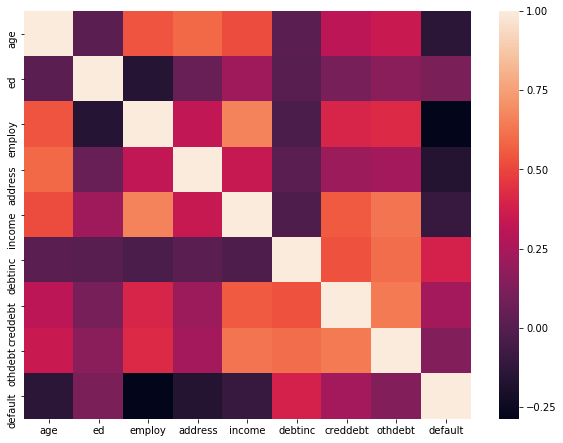

In [42]:
# Visualize the correlation matrix using a heatmap
sns.heatmap(bankloans_existing.corr())

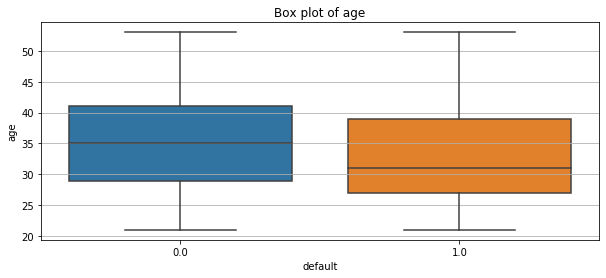

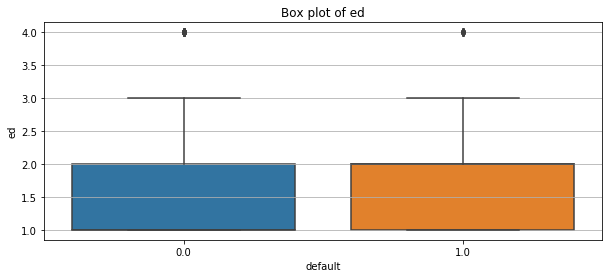

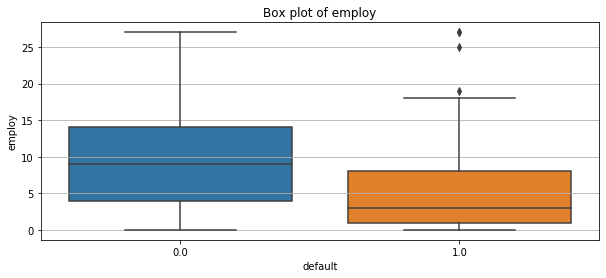

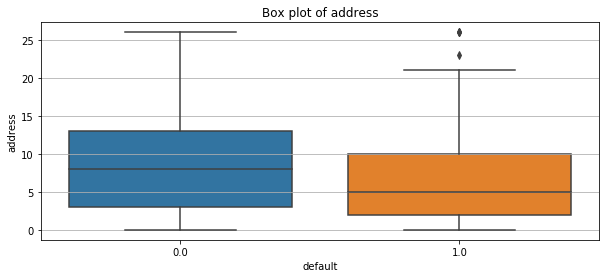

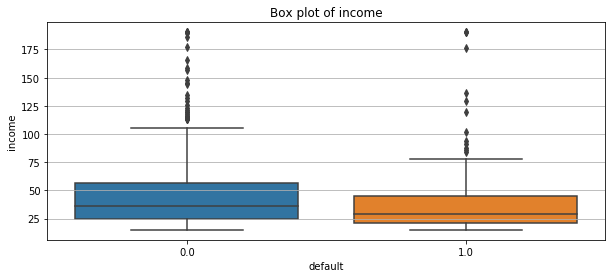

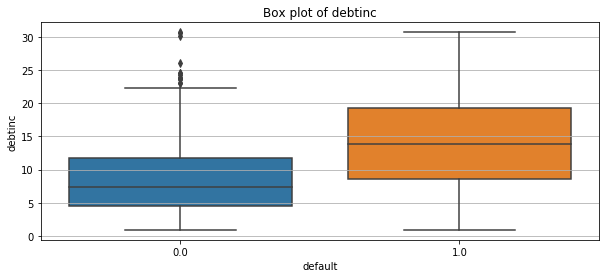

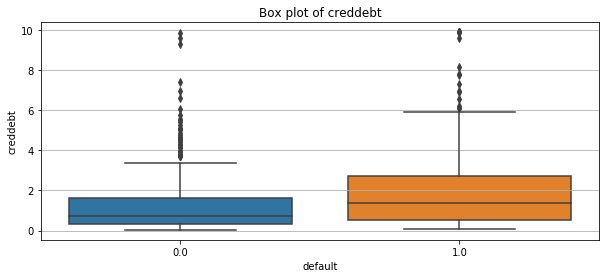

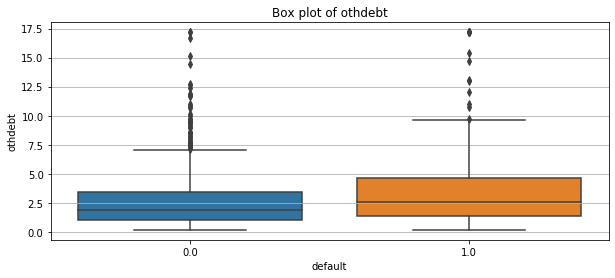

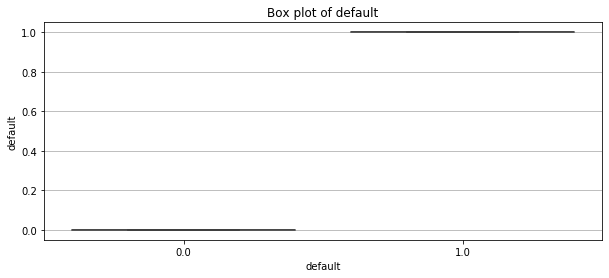

In [48]:
# Now we will use box plot to visualize each variable with respect to default column's value 0 and 1. 
# This will help us to understand if means are different for 0's and 1's. If yes then that variable is important.
num_variable_names = [key for key in dict(bankloan_df.dtypes) if dict(bankloan_df.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]

for variables in num_variable_names:
  fig, axes = plt.subplots(figsize = (10, 4))
  sns.boxplot(x='default', y=variables, data=bankloans_existing)
  plt.title('Box plot of {}'.format(variables))

## Data Exploratory analysis
- Bi-variate analysis - numeric (t-test) and categorical(chi-square test)

In [51]:
# numerical variable
# here we are going to perform independent t-test between 0's and 1's of each variable.
tstats_df = pd.DataFrame()
for variables in num_variable_names:
  tstats = stats.ttest_ind(bankloans_existing[bankloans_existing['default']==1][variables],bankloans_existing[bankloans_existing['default']==0][variables])
  temp_df = pd.DataFrame([variables, tstats[0], tstats[1]]).T
  temp_df.columns = ['Variable Name', 'T-Statistic', 'P-value']
  tstats_df = pd.concat([tstats_df, temp_df], axis=0, ignore_index=True)

print(tstats_df)
# If we see the result below, At 95% confidence interval all the variables look significant

  Variable Name T-Statistic      P-value
0           age    -3.69893  0.000233527
1            ed     3.15351   0.00168236
2        employ    -7.92136  9.27995e-15
3       address    -4.43055  1.09104e-05
4        income    -2.64329   0.00839468
5       debtinc     11.1409  1.20241e-26
6      creddebt     6.47909   1.7428e-10
7       othdebt      3.7073  0.000226095
8       default         inf            0


- Variable Transformation: (i) Bucketing


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


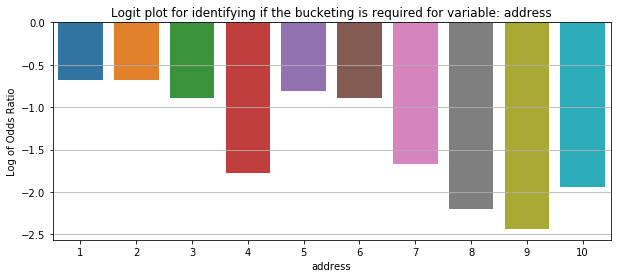

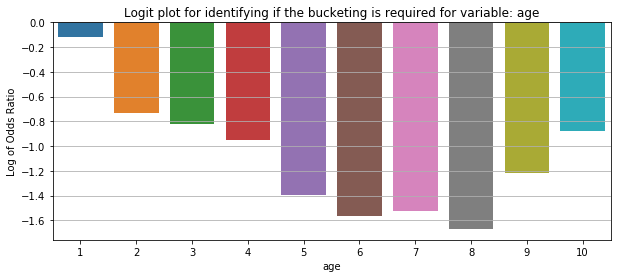

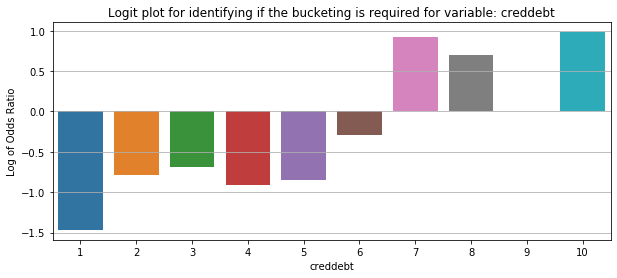

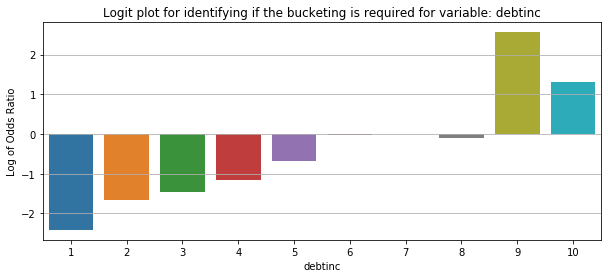

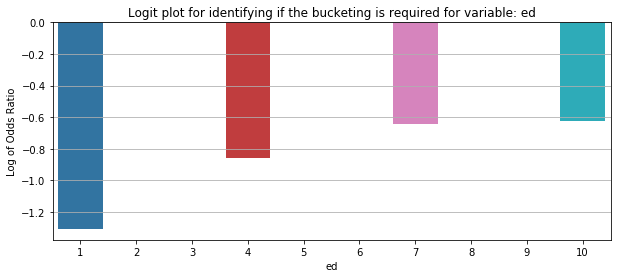

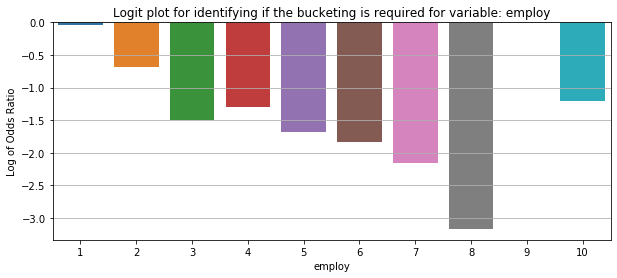

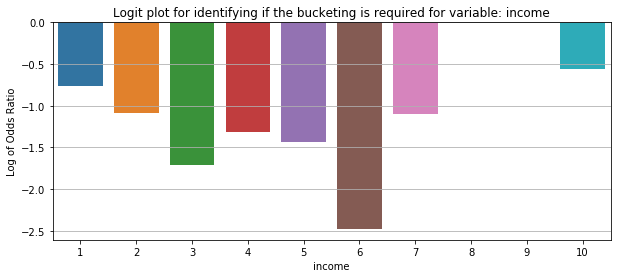

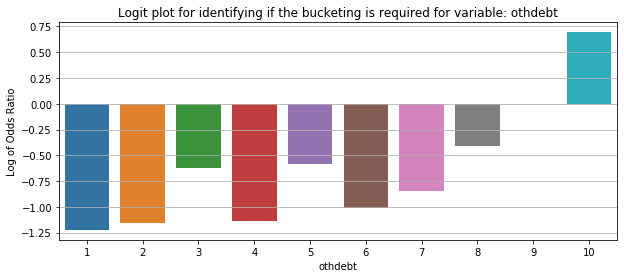

In [54]:
for variables in bankloans_existing.columns.difference(['default']):
  # divide numerical variable to 10 bins
  binned = pd.cut(bankloans_existing[variables], bins=10, labels=list(range(1,11)))
  binned = binned.dropna()
  # calculate odds ratio for each bin. 
  # taking sum() in nominator will add all 1's
  # taking total count() and subtracting sum() of 1's will give total count of 0's.
  # hence log(odds ratio) = p(y=1)/p(y=0)
  oddsratio = bankloans_existing.groupby(binned)['default'].sum() / (bankloans_existing.groupby(binned)['default'].count()-bankloans_existing.groupby(binned)['default'].sum())
  # find log of odds ratio
  oddsratio = np.log(oddsratio)
  fig, axes = plt.subplots(figsize=(10,4))
  sns.barplot(x=oddsratio.index,y=oddsratio)
  plt.ylabel('Log of Odds Ratio')
  plt.title('Logit plot for identifying if the bucketing is required for variable: {}'.format(variables))

In [55]:
# After analyzing the above bar plots we can say that below variables need bucketing
# creditdebt, othdebt, debtinc, employ, income
bankloans_existing[['creddebt', 'othdebt', 'debtinc', 'employ','income' ]].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
creddebt,700.0,1.498843,1.788451,0.030209,0.170020,0.301390,0.440418,0.593059,0.854869,1.183471,1.615023,2.288026,3.621504,9.891428
othdebt,700.0,3.027290,3.115401,0.160936,0.562232,0.900747,1.165766,1.546101,1.987567,2.511054,3.258777,4.577926,7.036180,17.184744
debtinc,700.0,10.222153,6.682160,0.900000,2.900000,4.500000,5.800000,7.000000,8.600000,10.500000,12.900000,15.440000,19.610000,30.701000
employ,700.0,8.358671,6.566008,0.000000,1.000000,2.000000,4.000000,5.600000,7.000000,9.000000,11.000000,14.000000,18.000000,27.010000
income,700.0,44.848714,31.942133,15.000000,19.000000,22.000000,26.000000,29.000000,34.000000,40.400000,49.000000,61.000000,82.000000,190.300000


In [0]:
# will update it later
#bucekting
#bankloans_existing['creddebt_extreme'] = bankloans_existing['creddebt'].apply(lambda x: 0 if 162 < x < 221 else 1)
#bankloans_existing['othdebt_extreme'] = bankloans_existing['othdebt'].apply(lambda x: 0 if 0.6 <= x < 0.84 else 1)
#bankloans_existing['debtinc_extreme'] = bankloans_existing['debtinc'].apply(lambda x: 0 if 0.6 <= x < 0.84 else 1)
#bankloans_existing['debtinc_extreme'].value_counts()

 - Variable Reduction using Somers' D values

In [57]:
# formula for Gini or somers' D is (2 * AUC - 1)
# we will do univariate regression for each variable and calculate somers' D to check which variable is significant

somersd_df = pd.DataFrame()
for variables in bankloans_existing.columns.difference(['default']):
  # creating the model
  logitreg = sm.logit(formula = str('default ~ ')+str(variables), data = bankloans_existing)
  # fit the model
  result = logitreg.fit()
  summary = result.summary()
  y_score = pd.DataFrame(result.predict())
  y_score.columns = ['Score']
  somersd = 2*metrics.roc_auc_score(bankloans_existing['default'], y_score) - 1
  temp_df = pd.DataFrame([variables, somersd]).T
  temp_df.columns = ['Variable Name','Somers D']
  somersd_df = pd.concat([somersd_df, temp_df], axis=0)

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


In [59]:
somersd_df
# we can see from below dataframe that debtinc and employ are the most important variables

,Variable Name,Somers D
0,address,0.222384
0,age,0.206329
0,creddebt,0.272378
0,debtinc,0.470506
0,ed,0.148302
0,employ,0.409138
0,income,0.200273
0,othdebt,0.173806


In [61]:
# VIF (variance inflation factor) analysis to check multicollinearity among variables

X = pd.concat([bankloans_existing[bankloans_existing.columns.difference(['default'])],bankloans_existing['default']], axis=1)
features = "+".join(bankloans_existing.columns.difference(['default']))
X.head()

,address,age,creddebt,debtinc,ed,employ,income,othdebt,default
0,12.0,41.0,9.891428,9.3,3,17.0,176.0,5.008608,1.0
1,6.0,27.0,1.362202,17.3,1,10.0,31.0,4.000798,0.0
2,14.0,40.0,0.856075,5.5,1,15.0,55.0,2.168925,0.0
3,14.0,41.0,2.658720,2.9,1,15.0,120.0,0.821280,0.0
4,0.0,24.0,1.787436,17.3,2,2.0,28.0,3.056564,1.0


In [62]:
features

'address+age+creddebt+debtinc+ed+employ+income+othdebt'

In [64]:
a,b = dmatrices(formula_like='default ~ '+ 'address+age+creddebt+debtinc+ed+employ+othdebt', data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)
# from the VIF factors we can see that creddebt, debtinc, employ, othdebt variables can be removed to avoid multicollinearity.

   VIF Factor   features
0   35.935809  Intercept
1    1.561693    address
2    1.995976        age
3    2.076815   creddebt
4    2.334000    debtinc
5    1.189361         ed
6    2.123688     employ
7    2.720089    othdebt


## Train and Test split for model building

In [66]:
train_features = X.columns.difference(['default'])
train_X, test_X = train_test_split(X, test_size=0.3, random_state=42)
print(train_X.columns)
print(test_X.columns)

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt', 'default'],
      dtype='object')
Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt', 'default'],
      dtype='object')


In [69]:
# building the model

logreg = sm.logit(formula='default ~ '+ "+".join(train_features), data = train_X)
result = logreg.fit()

result.summary2()
# we will look for variables with high p-values in summary and try to eliminate them and build the model again

Optimization terminated successfully.
         Current function value: 0.425391
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.275     
Dependent Variable: default          AIC:              434.8834  
Date:               2020-01-11 08:07 BIC:              472.6330  
No. Observations:   490              Log-Likelihood:   -208.44   
Df Model:           8                LL-Null:          -287.47   
Df Residuals:       481              LLR p-value:      4.0651e-30
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.3844    0.7360  -1.8808  0.0600  -2.8270   0.0582
address       -0.0853    0.0258  -3.3063  0.0009  -0.1359  -0.0348
age            0.0389    0.0202   1.9237  0.0544  -0.0007   0.0784
creddebt       0.6410    0.1385   4.6279  0.0000   0.3695   0.9125
debtinc        0.0353    0.0390   0.9067  0.3646  -0.0411   0.1117
ed             0.0080    0.1423   0.0563  0.9551  -0.2709   0.2870
employ        -0.2650    0.0399  -6.6413  0.0000  -0.3432  -0.1868
income        -0.0089    0.0123  -0.7215  0.4706  -0.0329   0.0152
othdebt        0.1249    0.1019   1.2259  0.2202  -0.0748   0.3246
=================================================================

"""

In [71]:
logreg = sm.logit(formula='default ~ address+debtinc+employ+othdebt' , data=train_X)
result = logreg.fit()

result.summary2()
# looking at the summary we can create mathematical equation using intercept and coef. Equation is given below:
# L = -0.0446*address + 0.0933*debtinc - 0.1667*employ + 0.1556*othdebt - 1.0362
# P(Y=1) = exp(L)/1+exp(L) we can either use this formula or use predict() method


Optimization terminated successfully.
         Current function value: 0.464656
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.208     
Dependent Variable: default          AIC:              465.3627  
Date:               2020-01-11 08:07 BIC:              486.3347  
No. Observations:   490              Log-Likelihood:   -227.68   
Df Model:           4                LL-Null:          -287.47   
Df Residuals:       485              LLR p-value:      6.5579e-25
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.0362    0.2870  -3.6107  0.0003  -1.5987  -0.4737
address       -0.0446    0.0199  -2.2350  0.0254  -0.0836  -0.0055
debtinc        0.0933    0.0230   4.0595  0.0000   0.0483   0.1383
employ        -0.1667    0.0279  -5.9725  0.0000  -0.2214  -0.1120
othdebt        0.1556    0.0594   2.6175  0.0089   0.0391   0.2721
=================================================================

"""

In [72]:
# compare gini or somers'D for train and test data
train_gini = 2*metrics.roc_auc_score(train_X['default'], result.predict()) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X['default'], result.predict(test_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)
# looking at gini index it appears that model was underfitted since train score is lower than test score. We should always take care of underfitting 
# and overfitting issues.

The Gini Index for the model built on the Train Data is :  0.6004947174241153
The Gini Index for the model built on the Test Data is :  0.701863354037267


## Finding cut off

Now we can compare actual value of 'default' column (Y-variable) and the probability calculated using predict() method and then come up with a cut-off value.

In [74]:
# Training data
# finding probability and comparing with actual Y-variable
train_predicted_prob = pd.DataFrame(result.predict(train_X))
train_predicted_prob.columns = ['prob']
train_actual = train_X['default']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

,actual,prob
357,1.0,0.668742
649,0.0,0.511699
291,0.0,0.101246
420,1.0,0.444934
177,0.0,0.209997


In [75]:
# Testing data
# finding probability and comparing with actual Y-variable
test_predicted_prob = pd.DataFrame(result.predict(test_X))
test_predicted_prob.columns = ['prob']
test_actual = test_X['default']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

,actual,prob
158,1.0,0.266069
500,0.0,0.444936
396,0.0,0.171193
155,0.0,0.306464
321,1.0,0.509099


In [0]:
# now we will find out sensitivity, specificity, FPR to decide the best cut-off value
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [81]:
roc_like_df

,cutoff,sensitivity,specificity
0,0.000000,1.000000,0.000000
0,0.020408,1.000000,0.084270
0,0.040816,0.992537,0.174157
0,0.061224,0.977612,0.221910
0,0.081633,0.970149,0.286517
0,0.102041,0.955224,0.356742
0,0.122449,0.925373,0.421348
0,0.142857,0.917910,0.471910
0,0.163265,0.902985,0.497191
0,0.183673,0.880597,0.544944


## Finding ideal cut-off

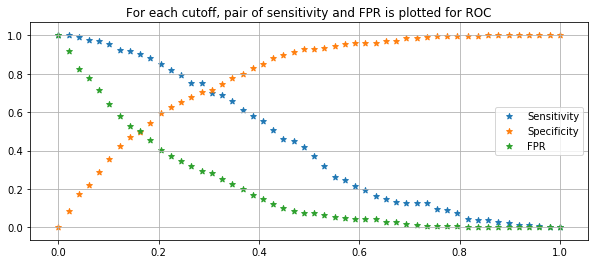

In [86]:
# plot a scatterplot for FPR (1-specificity), sensitivity, specificity
# the point where specificity and sensitivity will cross will be our best cut-off, since best cut-off will have highest sensitivity and specificity 
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [87]:
# we can also take sum of sensitivity and specificity and find the row which has highest value, that will be our best cut-off
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df

,cutoff,sensitivity,specificity,total
0,0.000000,1.000000,0.000000,1.000000
0,0.020408,1.000000,0.084270,1.084270
0,0.040816,0.992537,0.174157,1.166695
0,0.061224,0.977612,0.221910,1.199522
0,0.081633,0.970149,0.286517,1.256666
0,0.102041,0.955224,0.356742,1.311965
0,0.122449,0.925373,0.421348,1.346721
0,0.142857,0.917910,0.471910,1.389821
0,0.163265,0.902985,0.497191,1.400176
0,0.183673,0.880597,0.544944,1.425541


In [89]:
# get the best cut-off
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.285714,0.753731,0.705056,1.458788


## Create confusion matrix

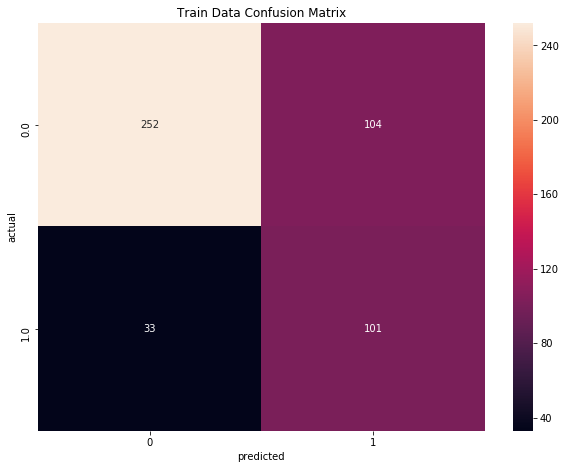

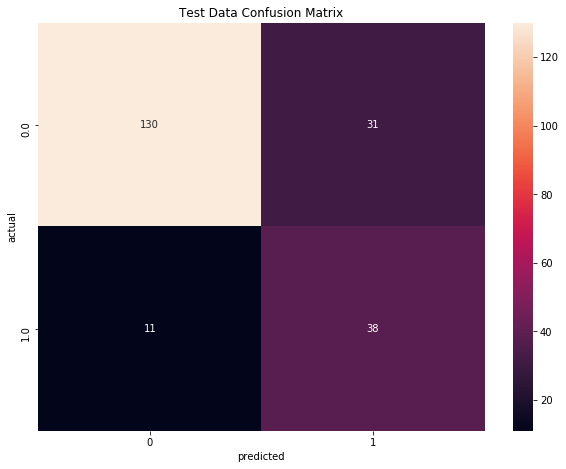

In [90]:
# use the cut-off value obtained in above step
# find predicted 0's and 1's. if probability is greater than cutoff then predicted = 1 or else 0
# test
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.29 else 0)
# train
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.29 else 0)
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()

In [91]:
# check overall accuracy score
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.7204081632653061
The overall accuracy score for the Test Data  is :  0.8


## Decile analysis to check if model is good
if probability is high it means customers are bad, if its low it means cutomers are good. if cutomer is bad more number of 1's should be captured.

steps:

create deciles using predicted probabilities and capture no of 0's and 1's. If probability is in decreasing order in deciles then no of 1's should also be in decreasing order.

In [93]:
train_predict['Deciles']=pd.qcut(train_predict['prob'],10, labels=False)
#test['Deciles']=pd.qcut(test['prob'],10, labels=False)
train_predict.head()

,actual,prob,predicted,Deciles
357,1.0,0.668742,1,9
649,0.0,0.511699,1,8
291,0.0,0.101246,0,2
420,1.0,0.444934,1,7
177,0.0,0.209997,0,4


In [96]:
# now group by deciles and take sum. arrange them in descending order.
df = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).sum().sort_index(ascending=False)
df
# check if both the columns are in descending order.

,Deciles,actual
Deciles,,
9,441,32.0
8,392,30.0
7,343,19.0
6,294,13.0
5,245,17.0
4,196,9.0
3,147,5.0
2,98,5.0
1,49,4.0
